In [73]:
import pandas as pd 
import numpy as np 
from skmultiflow.data.data_stream import DataStream
from skmultiflow.meta import AdaptiveRandomForestClassifier, StreamingRandomPatchesClassifier,\
OnlineBoostingClassifier, OnlineSMOTEBaggingClassifier
import itertools

from skmultiflow.evaluation import EvaluatePrequential
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
import glob

%matplotlib notebook

In [11]:
file_paths = '..//preprocessed_data/Sebastian/Preprocessed_without_anchor/multilabel/'
filenames = glob.glob(file_paths+"*[0-9].csv",recursive = True)
list_of_dfs = [pd.read_csv(filename,sep=';',header=0) for filename in filenames]

In [50]:
data_all = pd.DataFrame()
for dataframe, filename in zip(list_of_dfs, filenames):
    data_all=data_all.append(dataframe.iloc[:,-5:])
    #pd.concat(dataframe)

In [51]:
data=pd.DataFrame(data_all)
data.head(10)

,left1,left2,right2,right2.1,label
0,-533,-482,-333,-299,0
1,-437,-400,-266,-213,0
2,-359,-325,-171,-121,0
3,-285,-250,-85,-35,0
4,-207,-179,3,46,0
5,-145,-127,73,108,0
6,-105,-97,126,153,0
7,-77,-68,162,182,0
8,-50,-47,184,199,0
9,-35,-33,194,208,0


In [53]:
stream=DataStream(data)
stream.prepare_for_use()

/home/brooke/envs/p3_env/lib/python3.6/site-packages/skmultiflow/data/base_stream.py:194: FutureWarning: 'prepare_for_use' has been deprecated in v0.5.0 and will be removed in v0.7.0.
New instances of the Stream class are now ready to use after instantiation.
  category=FutureWarning)


### build meta-learning model 

#### train on adaptive random forest classifier

In [54]:
# Setup Adaptive Random Forest Classifier
arf = AdaptiveRandomForestClassifier()
# restart stream
stream.restart()

In [ ]:
evaluator = EvaluatePrequential(show_plot=True,
                                pretrain_size=10000,
                                max_samples=30000,
                                batch_size = 500,
                                output_file='../reports/results_arf.csv',
                                metrics=['accuracy', 'precision','recall','f1'])

In [ ]:
evaluator.evaluate(stream=stream, model=arf, model_names=['ARF'])

#### train  without realtime visualisation

In [55]:
stream.restart()
X, y = stream.next_sample(100000)

In [56]:
#pretrain with the first 10000 data
arf = AdaptiveRandomForestClassifier()
arf.fit(X,y)

/home/brooke/envs/p3_env/lib/python3.6/site-packages/skmultiflow/drift_detection/adwin.py:361: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


AdaptiveRandomForestClassifier(binary_split=False, disable_weighted_vote=False,
                               drift_detection_method=ADWIN(delta=0.001),
                               grace_period=50, lambda_value=6,
                               leaf_prediction='nba', max_byte_size=33554432,
                               max_features=2, memory_estimate_period=2000000,
                               n_estimators=10, nb_threshold=0,
                               no_preprune=False, nominal_attributes=None,
                               performance_metric='acc', random_state=None,
                               remove_poor_atts=False, split_confidence=0.01,
                               split_criterion='info_gain',
                               stop_mem_management=False, tie_threshold=0.05,
                               warning_detection_method=ADWIN(delta=0.01))

In [57]:
print(arf.score(X,y))

0.86215


In [61]:
# test on the remaing samples with batch size=100 and show the developement of accuracy using the pretrained arf model
scores = []
pred = []
y_true=[]
for i in range(int(stream.n_remaining_samples()/1000)):
    
    # Receive new data instances X
    X_test, _ = stream.next_sample(1000)
    
    # Compute predictions for new instances X
    y_predicted = arf.predict(X_test)
    # ... some time passes ...
    
    # Reception of true labels for data instances X
    y_test = stream.current_sample_y
    
    # Compute the prediction accuracy
    current_accuracy = accuracy_score(y_test, y_predicted)
    scores.append(current_accuracy)
    pred = np.append(pred,y_predicted)
    y_true = np.append(y_true, y_test)

In [62]:
def plot_score(scores):
    plt.figure()
    plt.plot(scores)
    plt.title('Development of prediction accuracy')
    plt.xlabel('Time')
    plt.ylabel('Prediction Accuracy')
    plt.show()

    print('Mean accuracy', np.mean(scores))

<IPython.core.display.Javascript object>


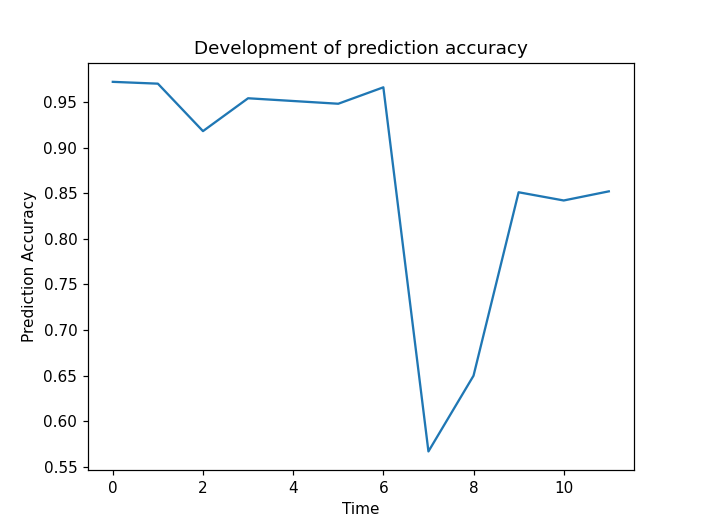

Mean accuracy 0.8700833333333334


In [63]:
plot_score(scores)

In [64]:
def plot_pred(y, pred):
    plt.figure()
    plt.plot(pred, 'rx',label ='prediction')
    plt.plot(y,'b.', label='target')
    plt.title('Development of prediction vs. target')
    plt.xlabel('Time')
    plt.ylabel('categoray')
    plt.legend(loc='lower right', bbox_to_anchor=(0.5, 0.8, 0.5, 0.5))
    plt.show()

<IPython.core.display.Javascript object>


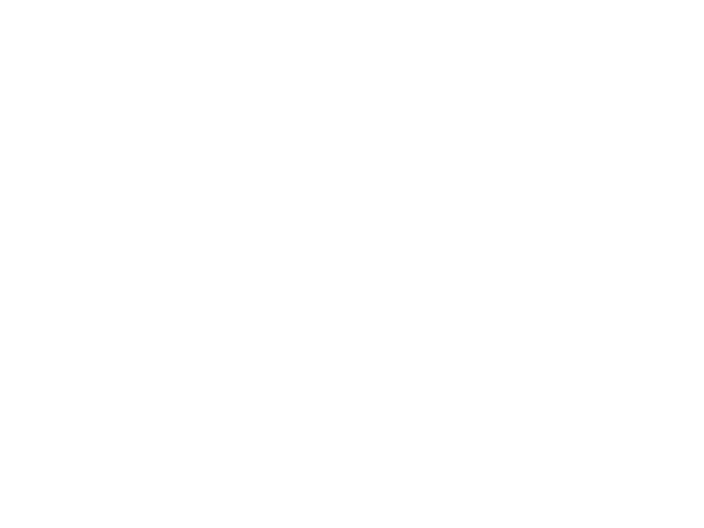

In [89]:
plot_pred(y_true,pred)

In [106]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color= "white" if cm[i, j] > thresh else"black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


<IPython.core.display.Javascript object>


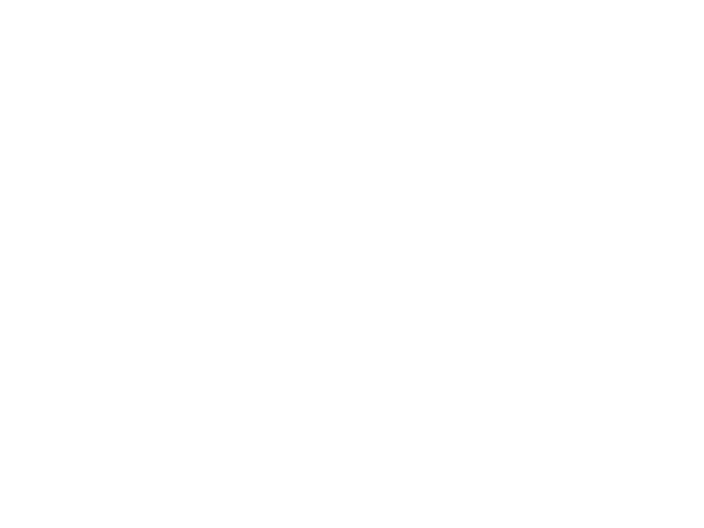

Confusion matrix, without normalization
[[10350   910     0     0    32]
 [  139    76     0     0     0]
 [  204     0     0     0     0]
 [   66    54     0     0     5]
 [   55    94     0     0    15]]


In [92]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, pred)
np.set_printoptions(precision=4)
class_names=['noTouch','nose', 'mouth', 'rightEye', 'leftEye']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,class_names, normalize=False)



<IPython.core.display.Javascript object>


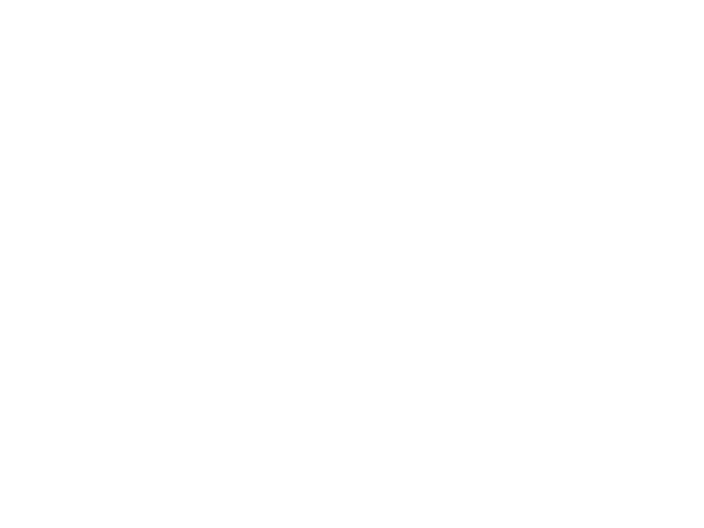

Normalized confusion matrix
[[0.9166 0.0806 0.     0.     0.0028]
 [0.6465 0.3535 0.     0.     0.    ]
 [1.     0.     0.     0.     0.    ]
 [0.528  0.432  0.     0.     0.04  ]
 [0.3354 0.5732 0.     0.     0.0915]]


In [93]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, pred)
np.set_printoptions(precision=4)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [95]:
# use partial fit to adaptive update the classifer on new data
stream.restart()
X, y = stream.next_sample(100000)
#pretrain with the first 10000 data
#arf = AdaptiveRandomForestClassifier()
#arf.fit(X,y)
partial_scores = []
pred = []
y_true=[]
for i in range(int(stream.n_remaining_samples()/300)):
    
    # Receive new data instances X
    X_test, _ = stream.next_sample(300)
    
    # Compute predictions for new instances X
    y_predicted = arf.predict(X_test)
    
    # ... some time passes ...
    
    # Reception of true labels for data instances X
    y_test = stream.current_sample_y
    
    # Compute the prediction accuracy
    current_accuracy = accuracy_score(y_test, y_predicted)
    partial_scores.append(current_accuracy)
    pred = np.append(pred,y_predicted)
    y_true = np.append(y_true, y_test)
    #Update of the prediction model
    arf.partial_fit(X_test, y_test)

<IPython.core.display.Javascript object>


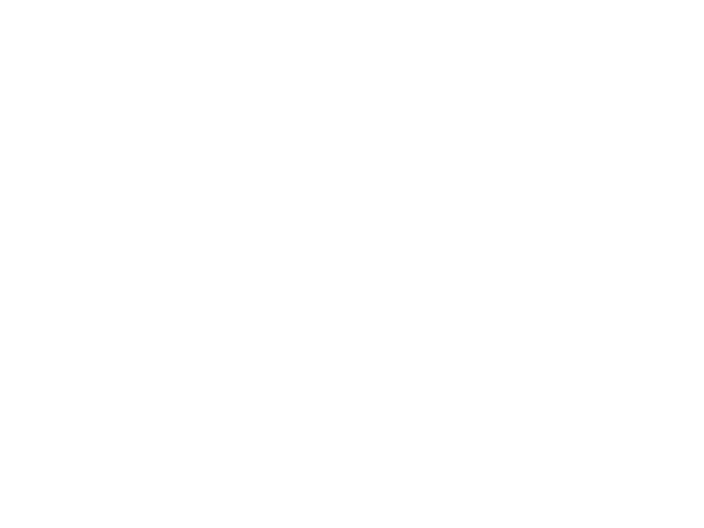

Mean accuracy 0.8466666666666666


In [96]:
plot_score(partial_scores)

<IPython.core.display.Javascript object>


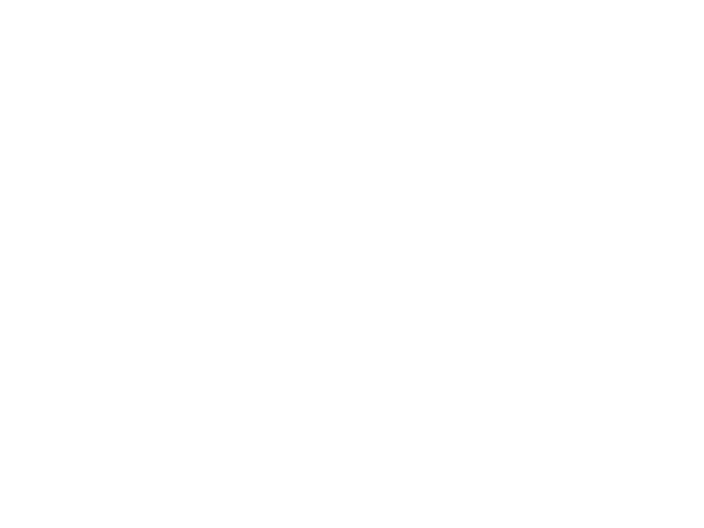

In [98]:
plot_pred(y_true,pred)

<IPython.core.display.Javascript object>


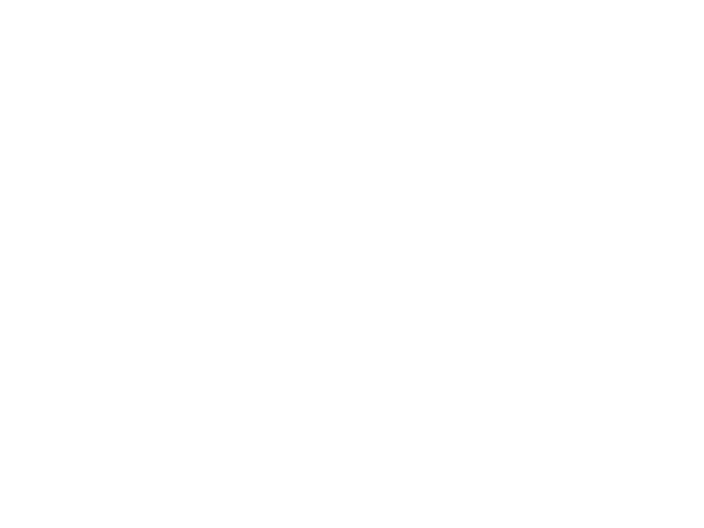

Normalized confusion matrix
[[0.8948 0.0319 0.0357 0.0099 0.0277]
 [0.9266 0.027  0.     0.     0.0463]
 [0.7206 0.     0.2794 0.     0.    ]
 [0.6957 0.1925 0.     0.1056 0.0062]
 [0.8402 0.0103 0.     0.067  0.0825]]


In [97]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, pred)
np.set_printoptions(precision=4)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [99]:
# retrain the model to adaptive updating
stream.restart()
X, y = stream.next_sample(100000)

#pretrain with the first 10000 data
arf = AdaptiveRandomForestClassifier()
arf.fit(X,y)
retrain_scores = []
pred_retrain = []
y_true=[]

for i in range(int(stream.n_remaining_samples()/300)):

    # Receive new data instances X
    X_test, _ = stream.next_sample(300)
    
    # Compute predictions for new instances
    y_predicted = arf.predict(X_test)
    
    # ... some time passes ...
    
    # Reception of true labels for data instances
    y_test = stream.current_sample_y
    
    # Compute the prediction accuracy
    current_accuracy = accuracy_score(y_test, y_predicted)
    retrain_scores.append(current_accuracy)
    pred_retrain = np.append(pred_retrain,y_predicted)
    y_true = np.append(y_true, y_test)
    #Retraining of the prediction model
    arf.fit(X_test, y_test)

<IPython.core.display.Javascript object>


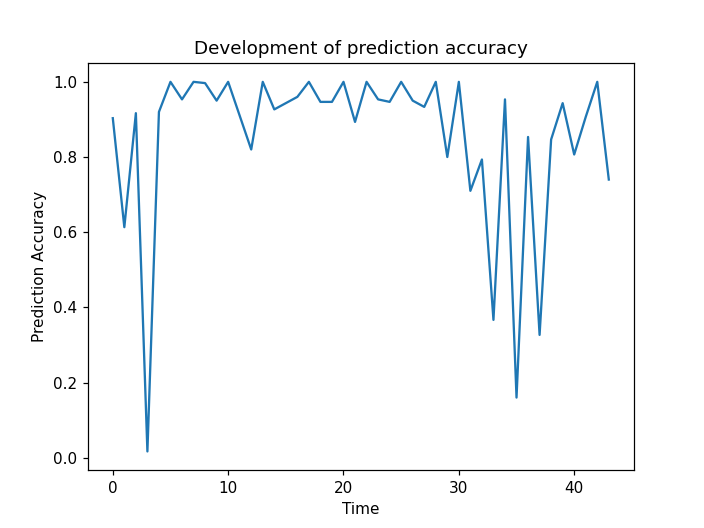

Mean accuracy 0.8546969696969697


In [100]:
plot_score(retrain_scores)

<IPython.core.display.Javascript object>


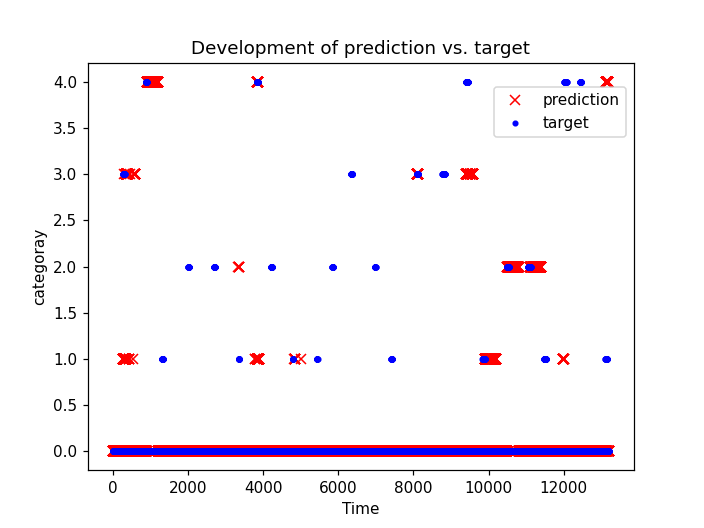

In [102]:
plot_pred(y_true,pred_retrain)

<IPython.core.display.Javascript object>


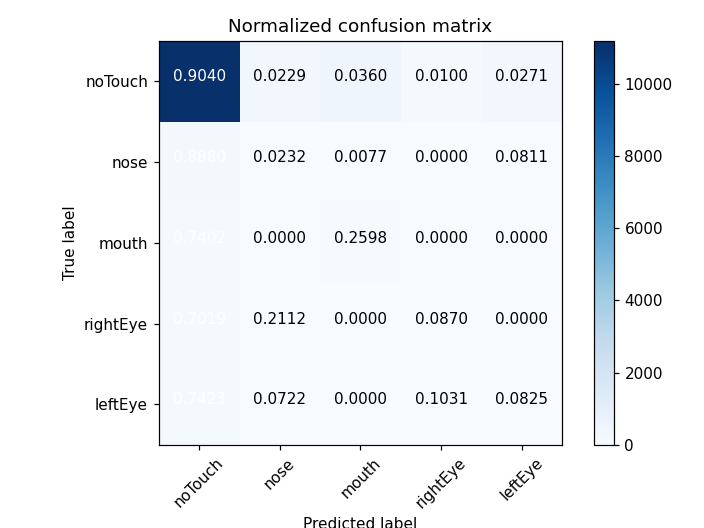

Normalized confusion matrix
[[0.904  0.0229 0.036  0.01   0.0271]
 [0.888  0.0232 0.0077 0.     0.0811]
 [0.7402 0.     0.2598 0.     0.    ]
 [0.7019 0.2112 0.     0.087  0.    ]
 [0.7423 0.0722 0.     0.1031 0.0825]]


In [108]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, pred_retrain)
np.set_printoptions(precision=4)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### train one sample once

In [9]:
# Setup variables to control loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = 30000

In [10]:
# Train the estimator with the samples provided by the data stream
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    y_pred = arf.predict(X)
    if y[0] == y_pred[0]:
        correct_cnt += 1
    arf.partial_fit(X, y)
    n_samples += 1

In [11]:
# Display results
print('Adaptive Random Forest ensemble classifier example')
print('{} samples analbyzed.'.format(n_samples))
print('Accuracy: {}'.format(correct_cnt / n_samples))

Adaptive Random Forest ensemble classifier example
24521 samples analbyzed.
Accuracy: 0.964520207169365


#### use Streaming random patches classifer

In [35]:
from skmultiflow.meta import StreamingRandomPatchesClassifier
# Setup Streaming Random Patches Classifier
srp = StreamingRandomPatchesClassifier(random_state=1,n_estimators=3)
# restart stream
stream.restart()

In [36]:
evaluator = EvaluatePrequential(show_plot=True,
                                pretrain_size=16000,
                                max_samples=30000,
                                batch_size = 500,
                                output_file='../reports/results_srp.csv',
                                metrics=['accuracy', 'precision','recall','f1'])

<IPython.core.display.Javascript object>


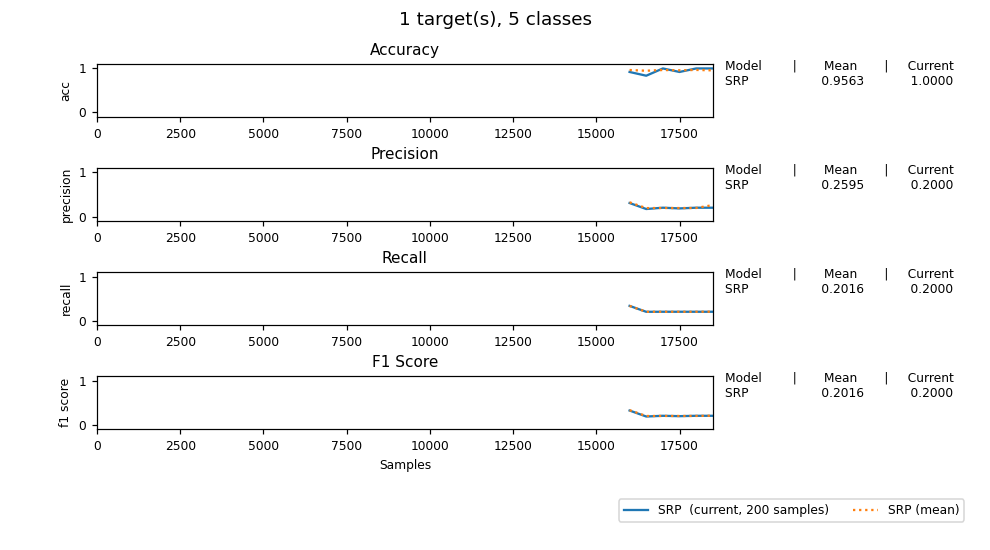

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 16000 sample(s).
Evaluating...
axis 1 is out of bounds for array of dimension 1
Processed samples: 19000
Mean performance:
SRP - Accuracy     : 0.9563
SRP - Precision: 0.2595
SRP - Recall: 0.2016
SRP - F1 score: 0.2016


/home/brooke/envs/p3_env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[StreamingRandomPatchesClassifier(base_estimator=HoeffdingTreeClassifier(binary_split=False,
                                                                         grace_period=50,
                                                                         leaf_prediction='nba',
                                                                         max_byte_size=33554432,
                                                                         memory_estimate_period=1000000,
                                                                         nb_threshold=0,
                                                                         no_preprune=False,
                                                                         nominal_attributes=None,
                                                                         remove_poor_atts=None,
                                                                         split_confidence=0.01,
                                                

In [37]:
evaluator.evaluate(stream=stream, model=srp, model_names=['SRP'])

In [18]:
# Variables to control loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = 30000

In [19]:
# Run test-then-train loop for max_samples
# or while there is data in the stream
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    y_pred = srp.predict(X)
    if y[0] == y_pred[0]:
        correct_cnt += 1
    srp.partial_fit(X, y)
    n_samples += 1

In [21]:
print('{} samples analyzed.'.format(n_samples))
# Display results
print('Streaming Random Patches Classifier example')
print('{} samples analyzed.'.format(n_samples))
print('Accuracy: {}'.format(correct_cnt / n_samples))

24321 samples analyzed.
Streaming Random Patches Classifier example
24321 samples analyzed.
Accuracy: 0.9539492619546893


#  Models for Imbalanced Data Streams


####  online boosting classifer and online bagging classifer

In [7]:
 from skmultiflow.meta import OnlineBoostingClassifier, OnlineSMOTEBaggingClassifier

In [6]:
# Setup the Online Boosting Classifier,SMOTEBagging ensemble classifier
online_boosting = OnlineBoostingClassifier()
online_smote_bagging = OnlineSMOTEBaggingClassifier()


In [7]:
# Set the evaluator
evaluator = EvaluatePrequential(max_samples=30000,
                            max_time=3000,
                            show_plot=True,
                            metrics=['accuracy', 'precision','recall','f1'])

<IPython.core.display.Javascript object>


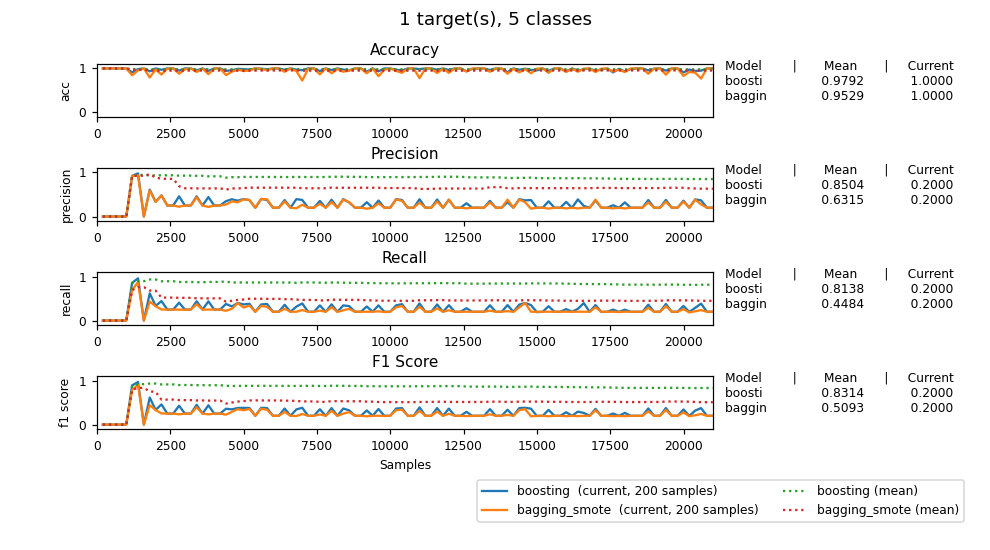

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################--- [85%] [2952.91s]
Time limit reached (3000.00s). Evaluation stopped.
Processed samples: 21041
Mean performance:
boosting - Accuracy     : 0.9792
boosting - Precision: 0.8504
boosting - Recall: 0.8138
boosting - F1 score: 0.8314
bagging_smote - Accuracy     : 0.9529
bagging_smote - Precision: 0.6315
bagging_smote - Recall: 0.4484
bagging_smote - F1 score: 0.5093


[OnlineBoostingClassifier(base_estimator=KNNADWINClassifier(leaf_size=30,
                                                            max_window_size=1000,
                                                            metric='euclidean',
                                                            n_neighbors=5),
                          drift_detection=True, n_estimators=None,
                          random_state=None),
 OnlineSMOTEBaggingClassifier(base_estimator=KNNADWINClassifier(leaf_size=30,
                                                                max_window_size=1000,
                                                                metric='euclidean',
                                                                n_neighbors=5),
                              drift_detection=True, n_estimators=10,
                              random_state=None, sampling_rate=1)]

In [8]:
evaluator.evaluate(stream=stream, model=[online_boosting,online_smote_bagging], model_names=['boosting','bagging_smote'])

<IPython.core.display.Javascript object>


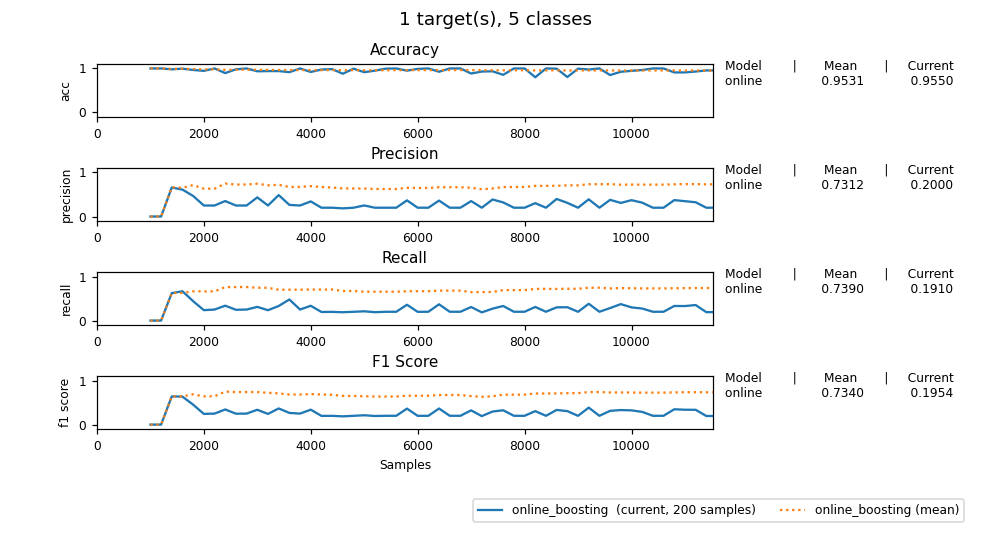

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [1338.93s]
Processed samples: 11521
Mean performance:
online_boosting - Accuracy     : 0.9531
online_boosting - Precision: 0.7312
online_boosting - Recall: 0.7390
online_boosting - F1 score: 0.7340


[OnlineBoostingClassifier(base_estimator=KNNADWINClassifier(leaf_size=30,
                                                            max_window_size=1000,
                                                            metric='euclidean',
                                                            n_neighbors=5),
                          drift_detection=True, n_estimators=None,
                          random_state=None)]

In [10]:
online_boosting = OnlineBoostingClassifier()
evaluator = EvaluatePrequential(max_samples=30000,
                                pretrain_size=1000,
                                show_plot=True,
                                metrics=['accuracy', 'precision','recall','f1'])
evaluator.evaluate(stream=stream, model=[online_boosting], model_names=['online_boosting'])

 #### use online under over bagging classifier

In [11]:
from skmultiflow.meta import OnlineUnderOverBaggingClassifier
online_under_over_bagging = OnlineUnderOverBaggingClassifier()
stream.restart()

In [12]:
evaluator = EvaluatePrequential(show_plot=True,
                                pretrain_size=1000,
                                max_samples=30000,
                                metrics=['accuracy', 'precision','recall','f1'])

<IPython.core.display.Javascript object>


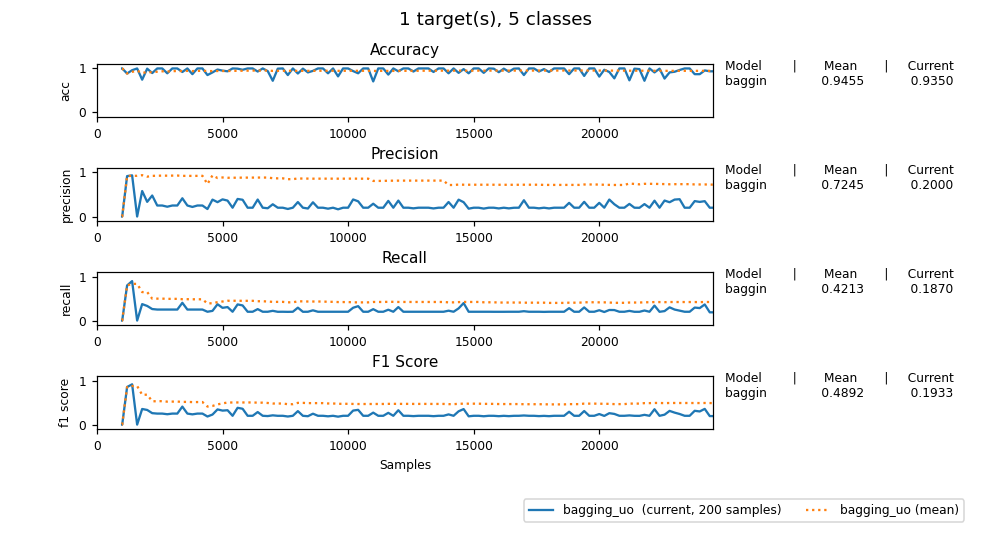

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [965.20s]
Processed samples: 24521
Mean performance:
bagging_uo - Accuracy     : 0.9455
bagging_uo - Precision: 0.7245
bagging_uo - Recall: 0.4213
bagging_uo - F1 score: 0.4892


[OnlineUnderOverBaggingClassifier(base_estimator=KNNADWINClassifier(leaf_size=30,
                                                                    max_window_size=1000,
                                                                    metric='euclidean',
                                                                    n_neighbors=5),
                                  drift_detection=True, n_estimators=10,
                                  random_state=None, sampling_rate=2)]

In [13]:
evaluator.evaluate(stream=stream, model=[online_under_over_bagging], model_names=['bagging_uo'])

In [14]:
# Variables to control loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = 30000

In [15]:
online_under_over_bagging = OnlineUnderOverBaggingClassifier()
stream.restart()

# build pipeline

In [ ]:
from skmultiflow.core import Pipeline
stream=DataStream(### data_list ###)
stream.prepare_for_use()
# restart stream if needed
stream.restart()

In [ ]:
transform = #prepocessing (####)
classifier = #Classifiername(#### paramter seting ####)

In [ ]:
# Setup the pipeline
pipe = Pipeline([('transform', transform), ('passive_aggressive', classifier)])
# Setup the evaluator
evaluator = EvaluatePrequential(show_plot=True, pretrain_size=1000, max_samples=500000)
# Evaluate
evaluator.evaluate(stream=stream, model=pipe)